In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import scipy.constants as sc

In [18]:
def generate_delta_sampling(delta_min, delta_max, step=None, num_points=None):
    if step is None and num_points is None:
        raise ValueError("Either 'step' or 'num_points' must be provided.")
    if step is None:
        step = (delta_max - delta_min) / num_points

    i_min = int(np.ceil(delta_min / step))
    i_max = int(np.floor(delta_max / step))

    arr = step * np.arange(i_min, i_max + 1)
    return arr

In [19]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [20]:
def twiss_scan(line, delta_min, delta_max, step=None, num_points=None):
    delta_values = generate_delta_sampling(delta_min, delta_max, step, num_points)
    
    idx_zero = np.where(delta_values == 0)[0][0]
    tw0 = line.twiss4d(delta0=0.0)
    twisses = []
    # twiss_pos.append(tw0)
    # twiss_neg.append(tw0)

    for delta in delta_values[:idx_zero][::-1]:
        twisses.append(line.twiss4d(delta0=delta, co_guess=twisses[-1].particle_on_co) if len(twisses)>0 else tw0)
    twisses = twisses[::-1]
    twisses.append(tw0)
    for delta in delta_values[idx_zero + 1:]:
        twisses.append(line.twiss4d(delta0=delta, co_guess=twisses[-1].particle_on_co))
    
    return delta_values, twisses

In [21]:
def plot_x(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    errs_neg = np.array([twiss.rows[loc].x[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[loc].x[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[loc].x[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[loc].x[0] for twiss in twisses_lin[idx_zero_lin:]])

    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg, color='red', label=f'{loc} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{loc} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg, color='red', linestyle='--', label=f'{loc} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{loc} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'x [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{loc}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

In [22]:
def plot_dx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    errs_neg = np.array([twiss.rows[loc].dx[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[loc].dx[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[loc].dx[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[loc].dx[0] for twiss in twisses_lin[idx_zero_lin:]])
    
    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg + lin_neg[-1] + lin_pos[0], color='red', label=f'{loc} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{loc} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg + errs_neg[-1] + errs_pos[0], color='red', linestyle='--', label=f'{loc} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{loc} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'Dx [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{loc}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

In [23]:
def plot_ddx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    errs_neg = np.array([twiss.rows[loc].ddx[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[loc].ddx[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[loc].ddx[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[loc].ddx[0] for twiss in twisses_lin[idx_zero_lin:]])
    
    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg + lin_neg[-1] + lin_pos[0], color='red', label=f'{loc} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{loc} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg + errs_neg[-1] + errs_pos[0], color='red', linestyle='--', label=f'{loc} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{loc} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'DDx [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{loc}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

In [24]:
def plot_betx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    errs_neg = np.array([twiss.rows[loc].betx[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[loc].betx[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[loc].betx[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[loc].betx[0] for twiss in twisses_lin[idx_zero_lin:]])
    
    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg + lin_neg[-1] + lin_pos[0], color='red', label=f'{loc} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{loc} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg + errs_neg[-1] + errs_pos[0], color='red', linestyle='--', label=f'{loc} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{loc} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'βx [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{loc}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

# Error line

In [25]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()
env = line.env
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

# remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [26]:
# Add errors in line
tte = env.elements.get_table()
mask_rbends = tte.element_type == 'RBend'
mask_quads = tte.element_type == 'Quadrupole'
mask_sextupoles = tte.element_type == 'Sextupole'

mba = tte.rows[mask_rbends].rows['mba.*'].name
mbb = tte.rows[mask_rbends].rows['mbb.*'].name
qf = tte.rows[mask_quads].rows['qf.*'].name
qd = tte.rows[mask_quads].rows['qd.*'].name
lsf = tte.rows[mask_sextupoles].rows['lsf.*'].name
lsd = tte.rows[mask_sextupoles].rows['lsd.*'].name

for nn in mba:
    env[nn].knl = np.array([0., 0., 2.12e-3, 0., -5.74, 0.])

for nn in mbb:
    env[nn].knl = np.array([0., 0., -3.19e-3, 0., -5.10, 0.])

for nn in qf:
    env[nn].knl = np.array([0., 0., 0., 0.75e-1, 0., -0.87e3])

for nn in qd:
    env[nn].knl = np.array([0., 0., 0., -2.03e-1, 0., 2.04e3])

In [27]:
# Match tune and chroma
env.vars['qph_setvalue'] = 0.5
env.vars['qpv_setvalue'] = 0.5
qx = 20.13
qy = 20.18
opt = line.match(
    method='6d', # <- passed to twiss
    vary=[
        xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
        xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
    ],
    targets = [
        xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
        xt.TargetSet(dqx=0.5*qx, dqy=0.5*qy, tol=1e-2, tag='chrom'),
    ])

                                             
Optimize - start penalty: 13.73                             
Matching: model call n. 13 penalty = 3.3521e-06              
Optimize - end penalty:  3.35215e-06                            


In [28]:
for nn in lsf:
    env[nn].k2 = 0
for nn in lsd:
    env[nn].k2 = 0

In [29]:
num_points = 2000
step= (0.79e-2 - (-0.79e-2)) / num_points

In [30]:
delta_values_errs, twisses_errs = twiss_scan(line, delta_min=0.0e-2, delta_max=0.5e-2, step=1e-4)
idx_zero_errs = np.where(delta_values_errs == 0)[0][0]



Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.




ClosedOrbitSearchError: 

# Linear line

In [ ]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()
env = line.env
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

# remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [ ]:
# Match tune and chroma
env.vars['qph_setvalue'] = 0.5
env.vars['qpv_setvalue'] = 0.5
qx = 20.13
qy = 20.18
opt = line.match(
    method='6d', # <- passed to twiss
    vary=[
        xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
        xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
    ],
    targets = [
        xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
        xt.TargetSet(dqx=0.5*qx, dqy=0.5*qy, tol=1e-2, tag='chrom'),
    ])

                                             
Optimize - start penalty: 1.178                             
Matching: model call n. 7 penalty = 3.4867e-04              
Optimize - end penalty:  0.000348674                            


In [ ]:
for nn in lsf:
    env[nn].k2 = 0
for nn in lsd:
    env[nn].k2 = 0

In [ ]:
num_points = 2000
step= (1e-2 - (-1e-2)) / num_points

In [ ]:
delta_values_lin, twisses_lin = twiss_scan(line, delta_min=-1e-2, delta_max=1e-2, step=step)
idx_zero_lin = np.where(delta_values_lin == 0)[0][0]

# Plots

In [ ]:
tw = line.twiss()

## Loss locations for sweep

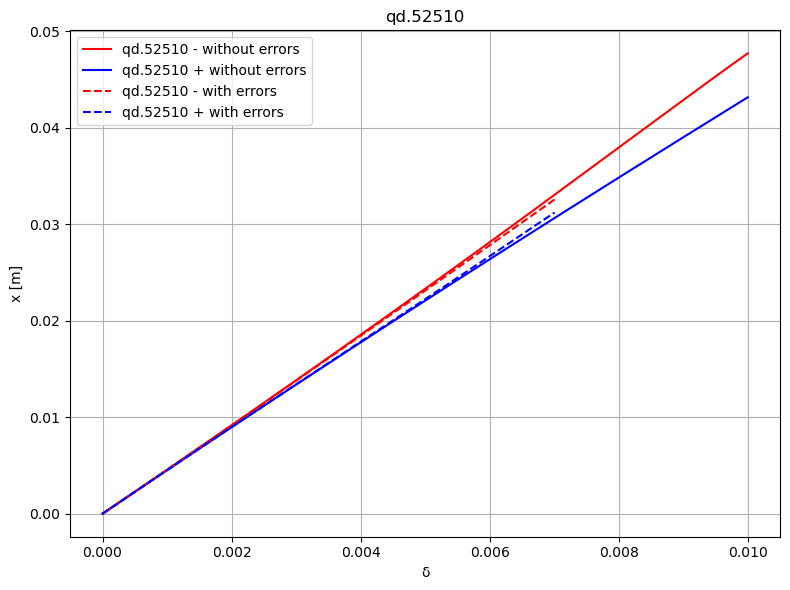

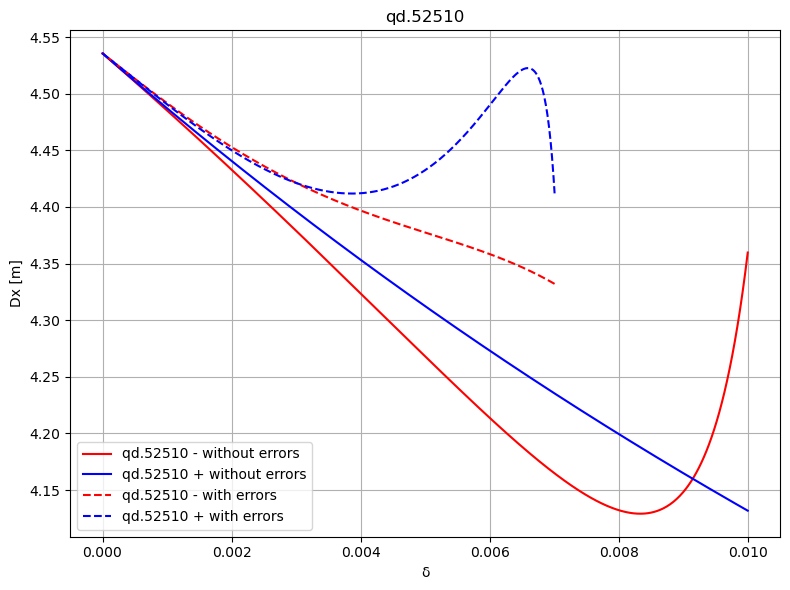

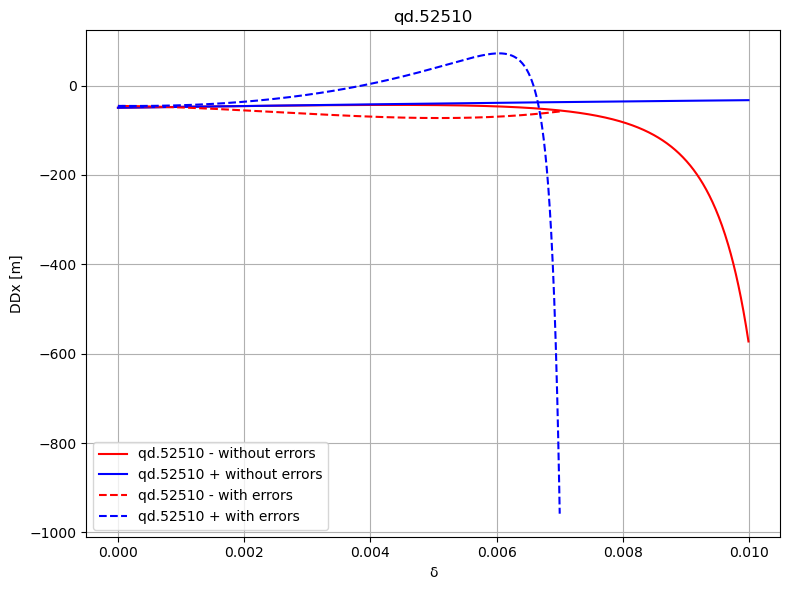

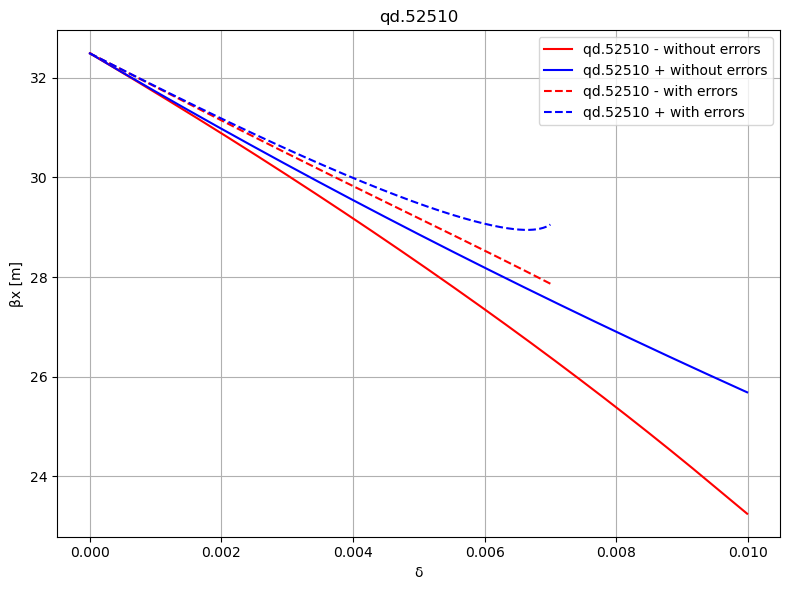

In [ ]:
loc = 'qd.52510'
fig, ax = plot_x(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_x')
fig, ax = plot_dx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_dx')
fig, ax = plot_ddx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_ddx')
fig, ax = plot_betx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_betx')

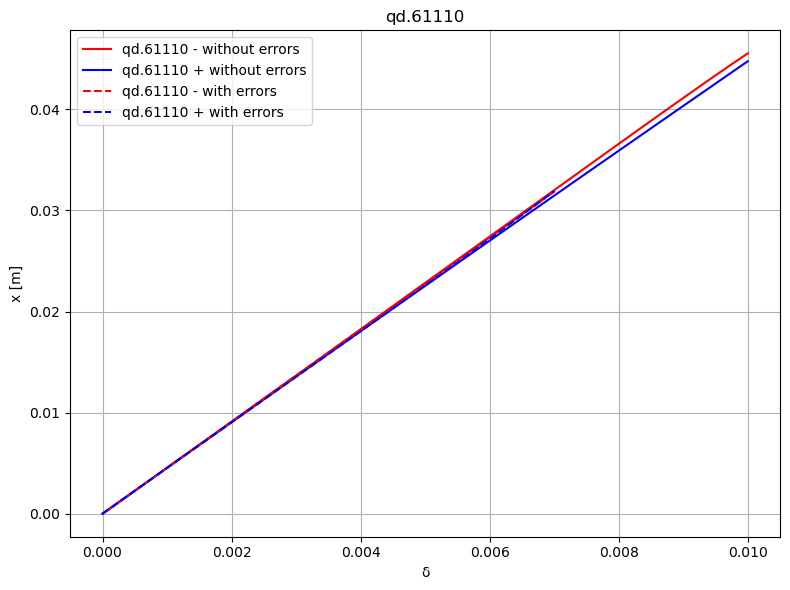

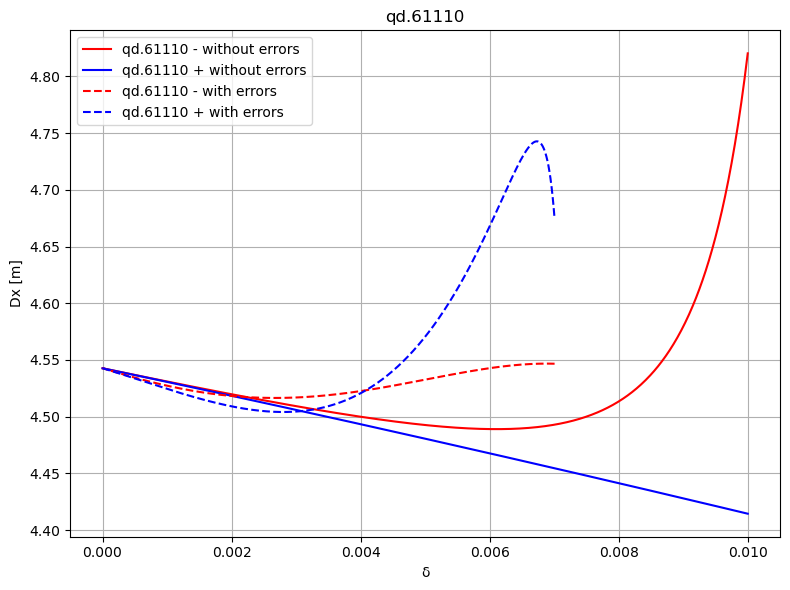

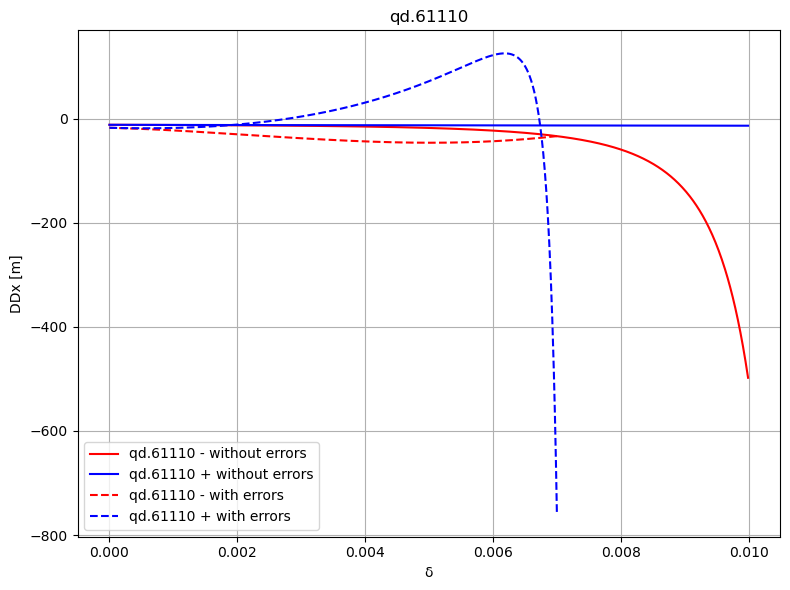

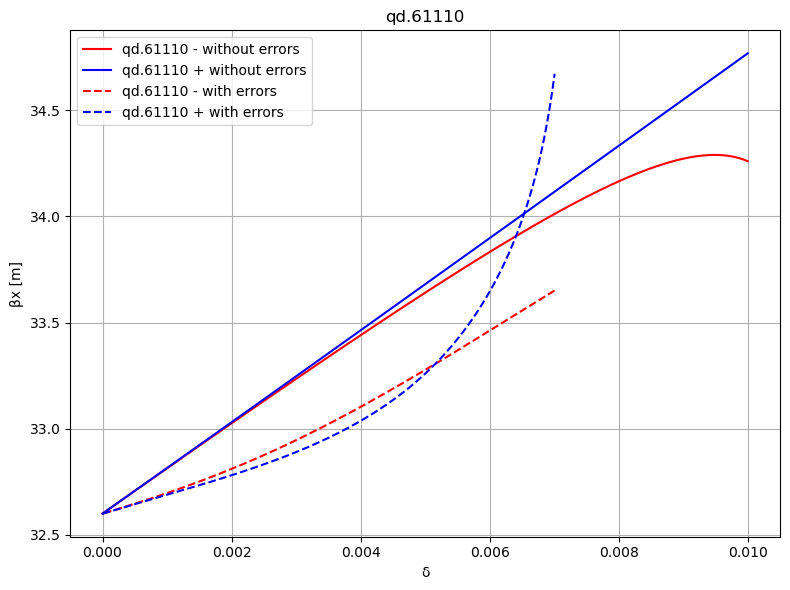

In [ ]:
loc = 'qd.61110'
fig, ax = plot_x(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_x')
fig, ax = plot_dx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_dx')
fig, ax = plot_ddx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_ddx')
fig, ax = plot_betx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_betx')

## Optics

In [ ]:
def calculate_bucket_height(line, f_RF=200.26e6, V_RF=3e6):
    # Calculate bucket height
    tw_ref = line.twiss4d()
    beta0 = line.particle_ref.beta0[0]
    E = line.particle_ref.energy0[0]
    q = line.particle_ref.q0
    h = f_RF * line.get_length() / beta0 / sc.c
    eta = tw_ref.slip_factor
    return np.sqrt(2*q*V_RF / (np.pi*h*abs(eta)*E*beta0**2))

def get_twisses(line, bucket_height):
    # Perform a bunch of twisses for different delta0
    tw = {}
    beam_sizes = {}
    nemitt = 2e-6
    for delta in np.linspace(-2*bucket_height, 2*bucket_height, 101):
        this_delta = round(delta,6)
        try:
            tw[this_delta] = line.twiss4d(delta0=delta)
            beam_sizes[this_delta] = tw[this_delta].get_beam_covariance(nemitt_x=nemitt, nemitt_y=nemitt)
        except:
            print(f"Failed for delta0={delta}")
            pass
    return tw, beam_sizes

In [ ]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()
env = line.env
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)
for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6


tte = env.elements.get_table()
mask_rbends = tte.element_type == 'RBend'
mask_quads = tte.element_type == 'Quadrupole'
mask_sextupoles = tte.element_type == 'Sextupole'

mba = tte.rows[mask_rbends].rows['mba.*'].name
mbb = tte.rows[mask_rbends].rows['mbb.*'].name
qf = tte.rows[mask_quads].rows['qf.*'].name
qd = tte.rows[mask_quads].rows['qd.*'].name
lsf = tte.rows[mask_sextupoles].rows['lsf.*'].name
lsd = tte.rows[mask_sextupoles].rows['lsd.*'].name

for nn in mba:
    env[nn].knl = np.array([0., 0., 2.12e-3, 0., -5.74, 0.])

for nn in mbb:
    env[nn].knl = np.array([0., 0., -3.19e-3, 0., -5.10, 0.])

for nn in qf:
    env[nn].knl = np.array([0., 0., 0., 0.75e-1, 0., -0.87e3])

for nn in qd:
    env[nn].knl = np.array([0., 0., 0., -2.03e-1, 0., 2.04e3])


env.vars['qph_setvalue'] = 0.5
env.vars['qpv_setvalue'] = 0.5
qx = 20.13
qy = 20.18
opt = line.match(
    method='6d', # <- passed to twiss
    vary=[
        xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
        xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
    ],
    targets = [
        xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
        xt.TargetSet(dqx=0.5*qx, dqy=0.5*qy, tol=1e-2, tag='chrom'),
    ])

tw_err, beam_sizes_err = get_twisses(line, calculate_bucket_height(line, V_RF=3e6))

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           
                                             
Optimize - start penalty: 13.73                             
Matching: model call n. 13 penalty = 3.3521e-06              
Optimize - end penalty:  3.35215e-06                            


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=-0.00596372923757783


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=0.00596372923757783


In [ ]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()
env = line.env
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)
for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6


env.vars['qph_setvalue'] = 0.5
env.vars['qpv_setvalue'] = 0.5
qx = 20.13
qy = 20.18
opt = line.match(
    method='6d', # <- passed to twiss
    vary=[
        xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
        xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
    ],
    targets = [
        xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
        xt.TargetSet(dqx=0.5*qx, dqy=0.5*qy, tol=1e-2, tag='chrom'),
    ])

tw_lin, beam_sizes_lin = get_twisses(line, calculate_bucket_height(line, V_RF=3e6))

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           
                                             
Optimize - start penalty: 1.178                             
Matching: model call n. 7 penalty = 3.4867e-04              
Optimize - end penalty:  0.000348674                            


In [ ]:
from make_aperture import tt_aper
import mplcursors

In [ ]:
def plot_momentum_aperture(tw, beam_sizes, bucket_height, figsize=(20, 4), savefig=None, xlim=None, ylim=None, tooltip=False):
    fig, ax = plt.subplots(figsize=figsize)
    delta = list(tw.keys())
    for dd in delta:
        if abs(dd) <= bucket_height + 1.e-12:
            ax.plot(tw[dd].s, tw[dd].x + np.sign(dd)*5*beam_sizes[dd].sigma_x, 'g-')
        else:
            ax.plot(tw[dd].s, tw[dd].x + np.sign(dd)*5*beam_sizes[dd].sigma_x, 'r-')
    line1, = ax.plot(tt_aper.s, tt_aper.aper_max_x, 'k-')
    line2, = ax.plot(tt_aper.s, tt_aper.aper_min_x, 'k-')
    ax.set_xlabel('s [m]')
    ax.set_ylabel('Aperture $x$ [m]')
    ax.set_title(f'Betatron {5}' + r'$\sigma_x$   $\delta$ within 1 bucket (green) and 2 buckets (red)')
    if tooltip:
        cursor = mplcursors.cursor([line1, line2])
        @cursor.connect("add")
        def on_add(sel):
            if hasattr(sel, 'index'):
                raw_idx = sel.index
            else:
                raw_idx = sel.target.index
            idx = int(raw_idx)
            sel.annotation.set_text(tt_aper.name[idx])
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    fig.tight_layout()
    if savefig is not None:
        plt.savefig(savefig, dpi=300)
    plt.show()
    return fig, ax

In [ ]:
tw.show()

name                     s             x            px             y            py          zeta ...
begi.10010               0             0             0             0             0             0
qf.10010                 0             0             0             0             0             0
drift_1              3.085             0             0             0             0             0
mba.10030          3.44501             0             0             0             0             0
drift_2            9.70503  -2.53435e-16  -8.35895e-17             0             0  -3.88578e-14
mba.10050           10.105  -2.86872e-16  -8.35895e-17             0             0  -3.88578e-14
drift_3            16.3651  -1.06652e-15  -1.67728e-16             0             0  -7.77156e-14
mbb.10070          16.7551  -1.13194e-15  -1.67728e-16             0             0  -7.77156e-14
drift_4            23.0151  -2.44032e-15  -2.51869e-16             0             0  -1.16573e-13
mbb.10090          23.3951

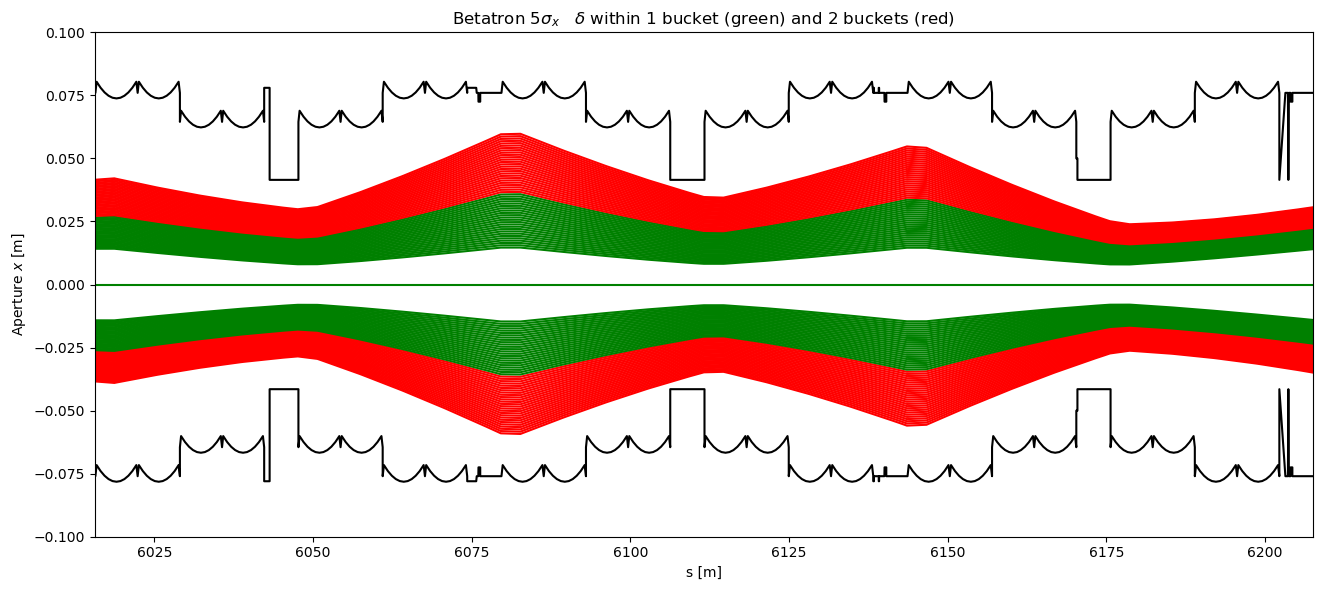

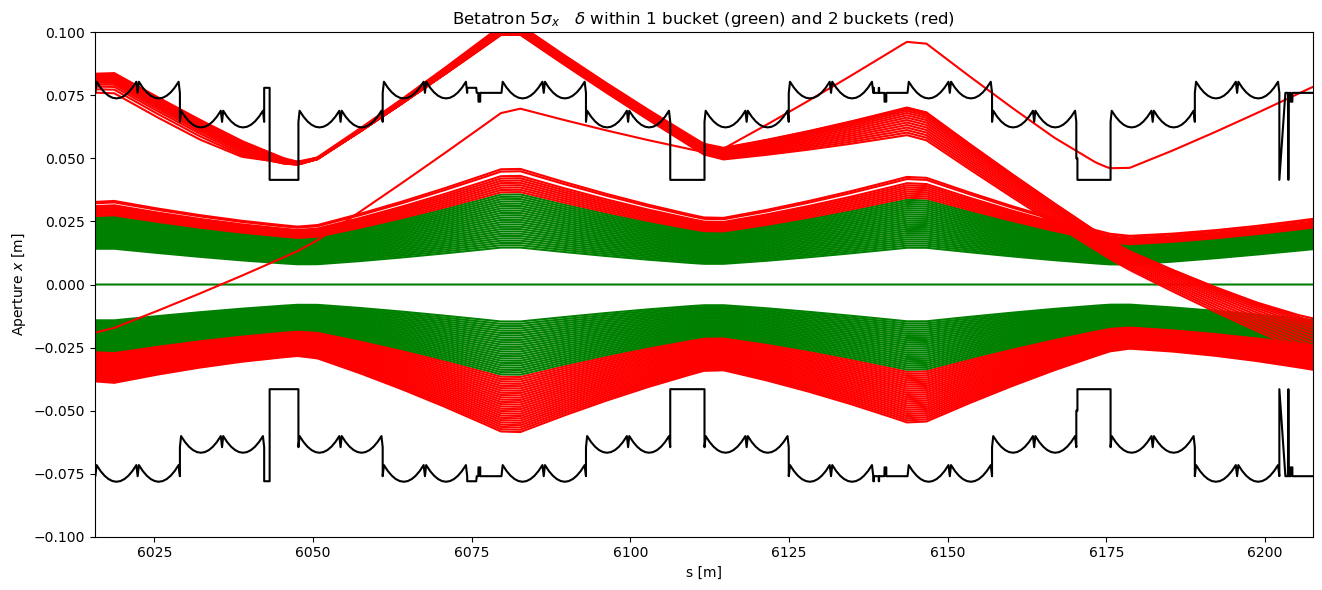

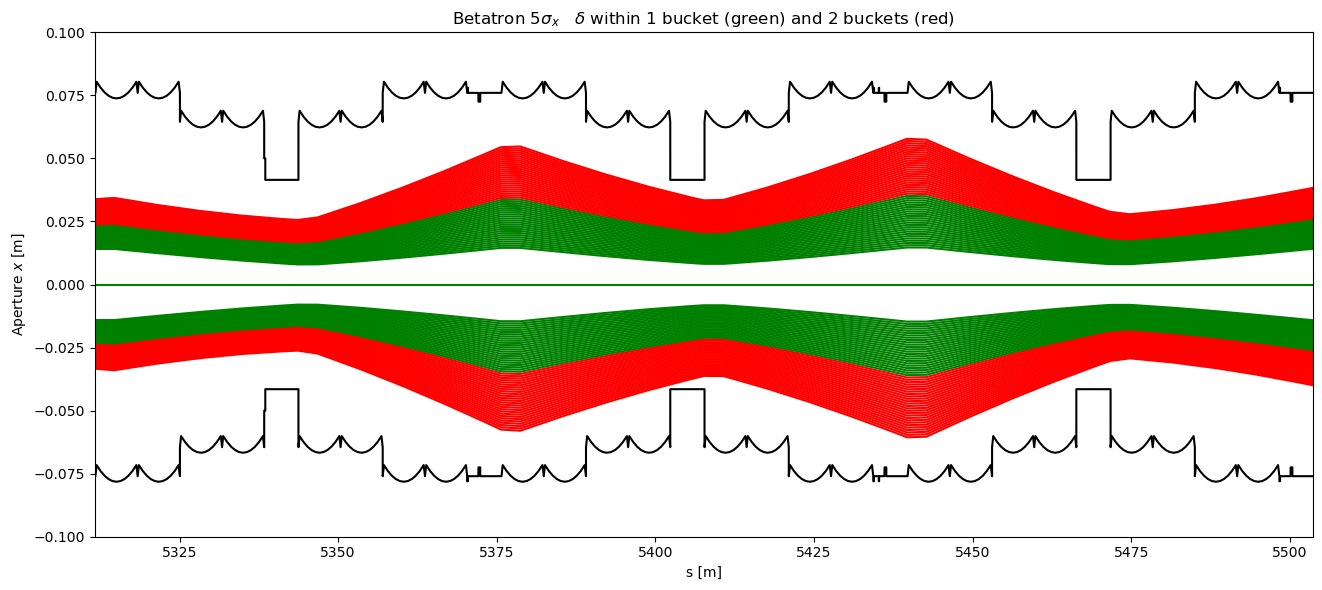

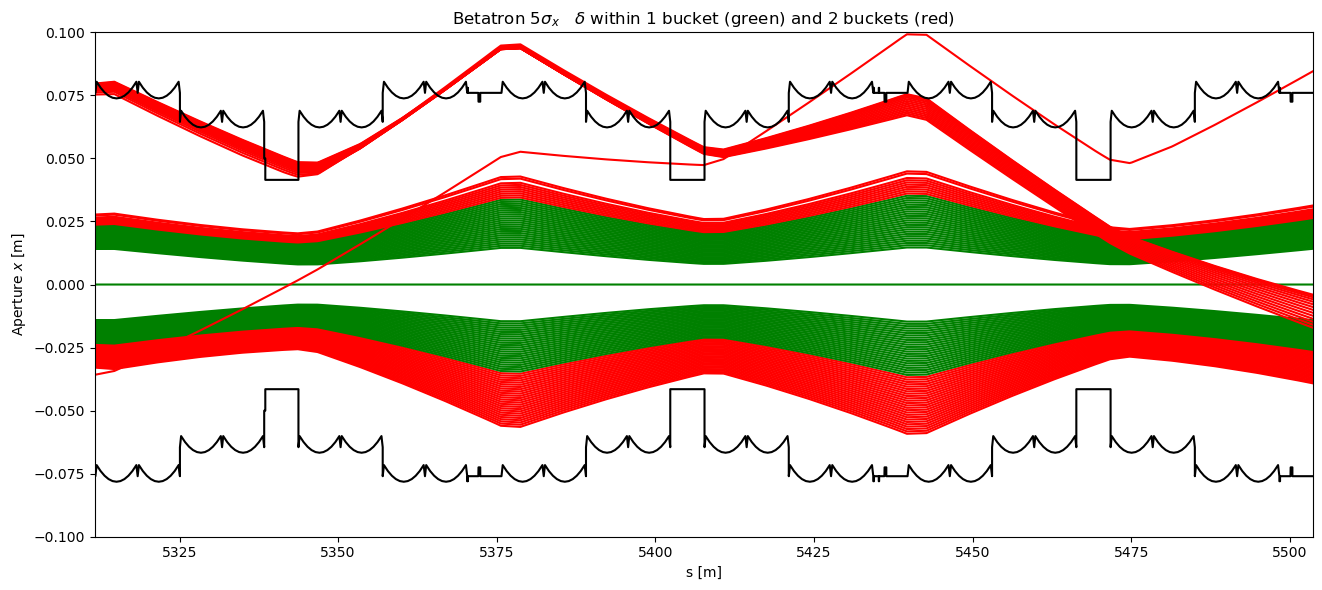

(<Figure size 1333x600 with 1 Axes>,
 <Axes: title={'center': 'Betatron 5$\\sigma_x$   $\\delta$ within 1 bucket (green) and 2 buckets (red)'}, xlabel='s [m]', ylabel='Aperture $x$ [m]'>)

In [ ]:
plot_momentum_aperture(tw_lin, beam_sizes_lin, calculate_bucket_height(line, V_RF=3e6), figsize=(13.33, 6), 
                       xlim=(tw.rows['qf.60810'].s, tw.rows['qf.61410'].s), ylim=(-0.1,0.1), savefig='Figures/momentum_aperture_lin_around_qd.61110.png')
plot_momentum_aperture(tw_err, beam_sizes_err, calculate_bucket_height(line, V_RF=3e6), figsize=(13.33, 6), 
                       xlim=(tw.rows['qf.60810'].s, tw.rows['qf.61410'].s), ylim=(-0.1,0.1), savefig='Figures/momentum_aperture_errs_around_qd.61110.png')
plot_momentum_aperture(tw_lin, beam_sizes_lin, calculate_bucket_height(line, V_RF=3e6), figsize=(13.33, 6), 
                       xlim=(tw.rows['qf.52210'].s, tw.rows['qf.52810'].s), ylim=(-0.1,0.1), savefig='Figures/momentum_aperture_lin_around_qd.52210.png')
plot_momentum_aperture(tw_err, beam_sizes_err, calculate_bucket_height(line, V_RF=3e6), figsize=(13.33, 6), 
                       xlim=(tw.rows['qf.52210'].s, tw.rows['qf.52810'].s), ylim=(-0.1,0.1), savefig='Figures/momentum_aperture_errs_around_qd.52210.png')